In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import glob
import os

from bs4 import BeautifulSoup
# data_path = '/Users/ruchiraravishankar/Downloads/iam_dataset/'
# data_path = '/content/drive/MyDrive/iam_dataset/'
data_path = '/content/drive/MyDrive/iam_dataset/'
save_path = '/content/drive/MyDrive/iam_dataset/saved_model'
save_model = False
save_results = False
if not os.path.exists(save_path):
  os.makedirs(save_path)

In [ ]:
labelled_data = np.load(data_path + "labelled_data.npy")
print(labelled_data.shape)

(4901, 2)


In [ ]:
labelled_data_0 = labelled_data[labelled_data[:,1] == '000']

print(labelled_data_0.shape)

labelled_data_0 = labelled_data_0[:196]
print(labelled_data_0.shape)

print(np.unique(labelled_data_0[:,1]))

(693, 2)
(196, 2)
['000']


In [ ]:
remove_000 = labelled_data[labelled_data[:,1]!='000']

print(np.unique(remove_000[:,1]))
print(np.unique(remove_000[:,1]).shape)

['085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204' '205'
 '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333' '334'
 '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345' '346'
 '347' '348' '349' '384' '415' '551' '552' '567' '588' '634' '635' '670'
 '671']
(49,)


In [ ]:
y = [remove_000[remove_000[:,1]==k] for k in np.unique(remove_000[:,1])]
print(len(y))

49


In [ ]:
labelled_data_1 = []
for i in y:
    labelled_data_1.append(i[:4])
print(len(labelled_data_1))

labelled_data_1 = np.array(labelled_data_1)

print(labelled_data_1.shape)

49
(49, 4, 2)


In [ ]:
labelled_data_1=labelled_data_1.reshape(-1,2)

In [ ]:
print(labelled_data_1.shape)

(196, 2)


In [ ]:
print(np.unique(labelled_data_1[:,1]))

['085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204' '205'
 '206' '207' '208' '209' '247' '248' '273' '274' '315' '332' '333' '334'
 '335' '336' '337' '338' '339' '340' '341' '342' '343' '344' '345' '346'
 '347' '348' '349' '384' '415' '551' '552' '567' '588' '634' '635' '670'
 '671']


In [ ]:
labelled_data_new = np.concatenate((labelled_data_0, labelled_data_1))
np.random.shuffle(labelled_data_new)
print(labelled_data_new.shape) # mix of sentences from writer id 0 and others, labelled

(392, 2)


In [ ]:
# split before augmenting to ensure the sentences are being split and not the augmented samples
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(labelled_data_new[:,0], labelled_data_new[:,1], test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(175,) (130,) (87,) (175,) (130,) (87,)


In [ ]:
from sklearn.utils import shuffle
from PIL import Image
import random

CROP_SIZE = 113
NUM_LABELS = 50

def get_augmented_sample(sample, label, sample_ratio):
    # Get current image details
    img = Image.open(sample)
    img_width = img.size[0]
    img_height = img.size[1]

    # Compute resize dimensions such that aspect ratio is maintained
    height_fac = CROP_SIZE / img_height
    size = (int(img_width * height_fac), CROP_SIZE)

    # Resize image 
    new_img = img.resize((size), Image.ANTIALIAS)
    new_img_width = new_img.size[0]
    new_img_height = new_img.size[1]

    # Generate a random number of crops of size 113x113 from the resized image
    x_coord = list(range(0, new_img_width - CROP_SIZE))
    num_crops = int(len(x_coord) * sample_ratio)
    random_x_coord = random.sample(x_coord, num_crops)
    
    # Create augmented images (cropped forms) and map them to a label (writer)
    images = []
    labels = []
    for x in random_x_coord:
        img_crop = new_img.crop((x, 0, x + CROP_SIZE, CROP_SIZE))
        # Transform image to an array of numbers
        images.append(np.asarray(img_crop))
        labels.append(label)

    return images, labels

In [ ]:
def augment(data, labels):
    augmented_sample_list = []
    augmented_label_list = []
    for i in range(len(data)):
        augmented_samples, augmented_labels = get_augmented_sample(data[i], labels[i],0.1)
        augmented_sample_list.append(augmented_samples)
        augmented_label_list.append(augmented_labels)
    return augmented_sample_list, augmented_label_list

In [ ]:
augsamps, auglbls = augment(X_train, y_train) # returns two lists of arrays
augsamps_test, auglbls_test = augment(X_test, y_test)
augsamps_val, auglbls_val = augment(X_val, y_val)

In [ ]:
import operator
from functools import reduce

# flattening the lists
aug_samps = reduce(operator.add, augsamps)
aug_lbls = reduce(operator.add, auglbls)

aug_samps_test = reduce(operator.add, augsamps_test)
aug_lbls_test = reduce(operator.add, auglbls_test)

aug_samps_val = reduce(operator.add, augsamps_val)
aug_lbls_val = reduce(operator.add, auglbls_val)

print(len(aug_samps))
print(len(aug_lbls))

print(len(aug_samps_test))
print(len(aug_lbls_test))

print(len(aug_samps_val))
print(len(aug_lbls_val))

27311
27311
19921
19921
12750
12750


In [ ]:
# converting lists to arrays
aug_samps_arr = np.array(aug_samps)
aug_lbls_arr = np.array(aug_lbls)
aug_samps_arr_test = np.array(aug_samps_test)
aug_lbls_arr_test = np.array(aug_lbls_test)
aug_samps_arr_val = np.array(aug_samps_val)
aug_lbls_arr_val = np.array(aug_lbls_val)

print(aug_samps_arr.shape)
print(aug_lbls_arr.shape)
print(aug_samps_arr_test.shape)
print(aug_lbls_arr_test.shape)
print(aug_samps_arr_val.shape)
print(aug_lbls_arr_val.shape)

(27311, 113, 113)
(27311,)
(19921, 113, 113)
(19921,)
(12750, 113, 113)
(12750,)


In [ ]:
X_train = aug_samps_arr
X_train = X_train.reshape(X_train.shape[0], 1, CROP_SIZE, CROP_SIZE)
X_train = X_train.astype('float16')
X_train /= 255.0
y_train = aug_lbls_arr


X_test = aug_samps_arr_test
X_test = X_test.reshape(X_test.shape[0], 1, CROP_SIZE, CROP_SIZE)
X_test = X_test.astype('float16')
X_test /= 255.0
y_test = aug_lbls_arr_test

X_val = aug_samps_arr_val
X_val = X_val.reshape(X_val.shape[0], 1, CROP_SIZE, CROP_SIZE)
X_val = X_val.astype('float16')
X_val /= 255.0
y_val = aug_lbls_arr_val



In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(27311, 1, 113, 113)
(27311,)
(19921, 1, 113, 113)
(19921,)
(12750, 1, 113, 113)
(12750,)


In [ ]:
new = np.unique(y_train)
print(new)

y_train[y_train !='000'] = 1
new = np.unique(y_train)
print(new)

y_train[y_train=='000'] = 0
new = np.unique(y_train)
print(new)

print(y_train.shape)

y_train = y_train.astype('float16')

print(np.unique(y_train))

['000' '085' '118' '150' '151' '152' '154' '155' '202' '203' '204' '205'
 '206' '207' '208' '209' '247' '248' '274' '315' '332' '333' '334' '335'
 '336' '337' '338' '339' '340' '341' '342' '343' '344' '345' '346' '347'
 '349' '384' '552' '567' '588' '634' '670' '671']
['000' '1']
['0' '1']
(27311,)
[0. 1.]


In [ ]:
new = np.unique(y_test)
print(new)

y_test[y_test !='000'] = 1
new = np.unique(y_test)
print(new)

y_test[y_test=='000'] = 0
new = np.unique(y_test)
print(new)

print(y_test.shape)

y_test = y_test.astype('float16')

print(np.unique(y_test))

['000' '085' '118' '150' '151' '152' '153' '154' '155' '202' '203' '204'
 '205' '206' '208' '247' '248' '273' '315' '332' '333' '334' '335' '336'
 '338' '339' '343' '344' '345' '346' '347' '348' '349' '384' '415' '551'
 '552' '567' '588' '634' '635' '671']
['000' '1']
['0' '1']
(19921,)
[0. 1.]


In [ ]:
new = np.unique(y_val)
print(new)

y_val[y_val !='000'] = 1
new = np.unique(y_val)
print(new)

y_val[y_val=='000'] = 0
new = np.unique(y_val)
print(new)

print(y_val.shape)

y_val = y_val.astype('float16')

print(np.unique(y_val))

['000' '085' '150' '151' '152' '153' '203' '204' '207' '209' '247' '273'
 '274' '332' '333' '335' '336' '337' '338' '340' '342' '343' '345' '348'
 '415' '551' '567' '588' '634' '635' '670']
['000' '1']
['0' '1']
(12750,)
[0. 1.]


In [ ]:
torch.manual_seed(42)
CUDA = True
device = torch.device('cuda' if CUDA else 'cpu')
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}
device

device(type='cuda')

In [ ]:
from torch.utils.data import TensorDataset, DataLoader


tensor_x_train = torch.Tensor(X_train).type(torch.cuda.FloatTensor) # transform to torch tensor
tensor_y_train = torch.Tensor(y_train).type(torch.cuda.FloatTensor).long()



# tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
# tensor_y_train = torch.Tensor(y_train).long()

train_dataset = TensorDataset(tensor_x_train,tensor_y_train) # create your datset
train_dataloader = DataLoader(train_dataset,batch_size=16, shuffle=True, drop_last=True) # create your dataloader

In [ ]:
tensor_x_val = torch.Tensor(X_val).type(torch.cuda.FloatTensor) # transform to torch tensor
tensor_y_val = torch.Tensor(y_val).type(torch.cuda.FloatTensor).long()
# tensor_x_train = torch.Tensor(X_train) # transform to torch tensor
# tensor_y_train = torch.Tensor(y_train).long()

val_dataset = TensorDataset(tensor_x_val,tensor_y_val) # create your datset
val_dataloader = DataLoader(val_dataset,batch_size=16, shuffle=True, drop_last=True) # create your dataloader

In [ ]:
tensor_x_test = torch.Tensor(X_test).type(torch.cuda.FloatTensor) # transform to torch tensor
tensor_y_test = torch.Tensor(y_test).long().type(torch.cuda.FloatTensor).long()

# tensor_x_test = torch.Tensor(X_test) # transform to torch tensor
# tensor_y_test = torch.Tensor(y_test).long()

test_dataset = TensorDataset(tensor_x_test,tensor_y_test) # create your datset
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, drop_last=True) # create your dataloader

In [ ]:
tensor_x_train.shape

torch.Size([27311, 1, 113, 113])

In [ ]:
import torch
from torch import nn
class Binary_Classifier(nn.Module): 
    def __init__(self):
        super(Binary_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv_drop = nn.Dropout2d()
        self.conv3 = nn.Conv2d(20, 30, kernel_size=3)
        self.fc1 = nn.Linear(4320, 1024)
        self.fc2 = nn.Linear(1024, 2)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(2)
    def forward(self, x):
        x = self.relu(self.max_pool2d(self.conv1(x)))
        x = self.relu(self.max_pool2d(self.conv_drop(self.conv2(x))))
        x = self.relu(self.max_pool2d(self.conv_drop(self.conv3(x))))
        x = x.view(x.shape[0],-1)
        # print(x.shape)
        x = self.relu(self.fc1(x))
        x = self.conv_drop(x)
        x = self.fc2(x)
        return x

In [ ]:
model=Binary_Classifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001)

# import torch.optim.lr_scheduler.StepLR
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)


In [ ]:
# train_losses = []
train_loss_record = []
valid_loss_record = []
# save_path = "/content/drive/MyDrive/iam_dataset/saved_model"

In [ ]:
from datetime import datetime
train_log_string = '%s :: Epoch %i :: Iter %i / %i :: train loss: %0.4f'
valid_log_string = '%s :: Epoch %i :: valid loss: %0.4f\n'
def train(epoch, best_record, criterion, optimizer):
    print('Start Epoch {} Training...'.format(epoch))
    model.train()
    train_loss = []
    train_loss_sum = []
    for idx, (data, target) in enumerate(train_dataloader):
        if torch.cuda.is_available():
          data, target = data.cuda(), target.cuda()   
        optimizer.zero_grad()
        #  forward-pass
        output = model(data)
        loss = criterion(output, target)
        #backward-pass
        loss.backward()
        # Update lr scheduler
        # scheduler.step()
        # Update the parameters
        optimizer.step()

        train_loss.append(loss.item())
        train_loss_sum.append(loss.item())
        if ((idx +1) % 64) == 0:
          print(train_log_string % (datetime.now(), epoch, idx + 1, len(train_dataloader), np.mean(train_loss)))
          print('Epoch-{0} lr: {1}'.format(epoch, optimizer.param_groups[0]['lr']))
          train_loss = []
    # mean_tr = torch.mean(torch.stack(train_loss_sum))
    mean_tr = np.mean(np.array(train_loss_sum))
    print('Train Loss at epoch {}: {}\n'.format(epoch, mean_tr))
    train_loss_record.append(mean_tr)


    print('Epoch {} Validating...'.format(epoch))

    
    valid_loss = []
    
    for idx, (data, target) in enumerate(val_dataloader):
        output = model(data)
        output = output.squeeze(1)
        loss = criterion(output, target)
        valid_loss.append(loss.item())
        mean_val = np.mean(np.array(valid_loss))
        print(valid_log_string % (datetime.now(), epoch, mean_val))
        valid_loss_record.append(mean_val)
    if np.mean(np.array(valid_loss)) < best_record:
        best_record = np.mean(np.array(valid_loss))
        # save the best model
        if save_model:
          state_dict = {
              'epoch': epoch,
              'model': model.state_dict(),
              'optimizer': optimizer.state_dict(),
          }
          torch.save(state_dict, save_path+'/model_3_convs.pt')
          print('Model saved!\n')
        
    print("DONE!")
    return train_loss_record, valid_loss_record, best_record

In [ ]:
import time
best = np.inf
train(1,best,criterion,optimizer)
torch.cuda.synchronize()
times = []
for epoch in range(15):
    start_epoch = time.time()
    tlr, vlr, best = train(epoch, best, criterion, optimizer)
    torch.cuda.synchronize()
    end_epoch = time.time()
    elapsed = end_epoch - start_epoch
    times.append(elapsed)


avg_time = sum(times)/15

Streaming output truncated to the last 5000 lines.
2022-04-08 13:04:13.699737 :: Epoch 11 :: valid loss: 0.3045

2022-04-08 13:04:13.704270 :: Epoch 11 :: valid loss: 0.3043

2022-04-08 13:04:13.708713 :: Epoch 11 :: valid loss: 0.3041

2022-04-08 13:04:13.713122 :: Epoch 11 :: valid loss: 0.3038

2022-04-08 13:04:13.717799 :: Epoch 11 :: valid loss: 0.3035

2022-04-08 13:04:13.722381 :: Epoch 11 :: valid loss: 0.3033

2022-04-08 13:04:13.726819 :: Epoch 11 :: valid loss: 0.3035

2022-04-08 13:04:13.731198 :: Epoch 11 :: valid loss: 0.3032

2022-04-08 13:04:13.735830 :: Epoch 11 :: valid loss: 0.3030

2022-04-08 13:04:13.740372 :: Epoch 11 :: valid loss: 0.3027

2022-04-08 13:04:13.745144 :: Epoch 11 :: valid loss: 0.3025

2022-04-08 13:04:13.749457 :: Epoch 11 :: valid loss: 0.3023

2022-04-08 13:04:13.754272 :: Epoch 11 :: valid loss: 0.3021

2022-04-08 13:04:13.758813 :: Epoch 11 :: valid loss: 0.3021

2022-04-08 13:04:13.763019 :: Epoch 11 :: valid loss: 0.3018

2022-04-08 13:04:13

In [ ]:
# training time 26.658623886108398
print(avg_time)

30.423797178268433


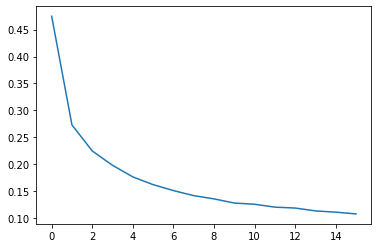

In [ ]:
# temp = [t.detach().cpu().numpy() for t in tlr]
# arr = np.array(temp)
# print(arr.shape)
import matplotlib.pyplot as plt
plt.plot(tlr)

In [ ]:
import os

if os.path.exists(save_path +'/model_3_convs.pt'):
    print('Loading checkpoint: %s' %save_path +'/model_3_convs.pt')
    path = torch.load(save_path +'/model_3_convs.pt')
    epoch = path['epoch']
    model.load_state_dict(path['model'])
    optimizer.load_state_dict(path['optimizer'])
else:
  print("DID NOT DO ANYTHING")

Loading checkpoint: /content/drive/MyDrive/testing_proj/iam_dataset/saved_model/model_3_convs.pt


In [ ]:
result = []
prediction = []
model.eval()
with torch.no_grad():
    for idx, (data, target) in enumerate(test_dataloader):
        output = model(data)
        output_sm = nn.Softmax(dim=1)(output)
        _, predicted = torch.max(output, 1)
        prediction.append(predicted)
        result.append(output_sm)
        
result = torch.stack(result).detach().cpu().numpy()
prediction = torch.stack(prediction).detach().cpu().numpy()

print(result.shape, prediction.shape)

(1245, 16, 2) (1245, 16)


In [ ]:
print(prediction.reshape(-1).shape)

(19920,)


In [ ]:
import pandas as pd
res = pd.DataFrame(result.reshape(-1,2))
pred = pd.DataFrame(prediction.reshape(-1))

# res.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/results_conv_3.csv", header=False, index=False)
# pred.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/pred_conv_3.csv", header=False, index=False)

In [ ]:
print(res.shape, pred.shape)

(19920, 2) (19920, 1)


In [ ]:
y_test_new = y_test[:result.reshape(-1,2).shape[0]]

In [ ]:
print(y_test_new.shape)

(19920,)


In [ ]:
result_df = pd.DataFrame({'ground truth': y_test_new, 'NN output': prediction.reshape(-1), 'probs 0': res[0], 'probs 1': res[1]})
result_df

,ground truth,NN output,probs 0,probs 1
0,1.0,1,0.010458,0.989542
1,1.0,1,0.081027,0.918973
2,1.0,1,0.204330,0.795670
3,1.0,0,0.640818,0.359182
4,1.0,1,0.199982,0.800018
...,...,...,...,...
19915,1.0,1,0.001579,0.998421
19916,1.0,1,0.096014,0.903986
19917,1.0,1,0.009300,0.990700
19918,1.0,1,0.002335,0.997665


In [ ]:
print(result_df)
# result_df.to_csv("/content/drive/MyDrive/iam_dataset/saved_model/result_df_conv_3.csv")

       ground truth  NN output   probs 0   probs 1
0               1.0          1  0.010458  0.989542
1               1.0          1  0.081027  0.918973
2               1.0          1  0.204330  0.795670
3               1.0          0  0.640818  0.359182
4               1.0          1  0.199982  0.800018
...             ...        ...       ...       ...
19915           1.0          1  0.001579  0.998421
19916           1.0          1  0.096014  0.903986
19917           1.0          1  0.009300  0.990700
19918           1.0          1  0.002335  0.997665
19919           1.0          1  0.002362  0.997638

[19920 rows x 4 columns]


In [ ]:
# work out the accuracy and other metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
actual = result_df['ground truth']
predicted = result_df['NN output']
# confusion matrix
matrix = confusion_matrix(actual, predicted, labels=[0,1])
print('Confusion matrix : \n',matrix)

# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(actual, predicted, labels=[0,1]).reshape(-1)
print('Outcome values : \n', tp, fn, fp, tn)

# classification report for precision, recall f1-score and accuracy
matrix_2 = classification_report(actual,predicted,labels=[1,0])
print('Classification report : \n',matrix_2)

Confusion matrix : 
 [[10598   803]
 [  760  7759]]
Outcome values : 
 10598 803 760 7759
Classification report : 
               precision    recall  f1-score   support

           1       0.91      0.91      0.91      8519
           0       0.93      0.93      0.93     11401

    accuracy                           0.92     19920
   macro avg       0.92      0.92      0.92     19920
weighted avg       0.92      0.92      0.92     19920



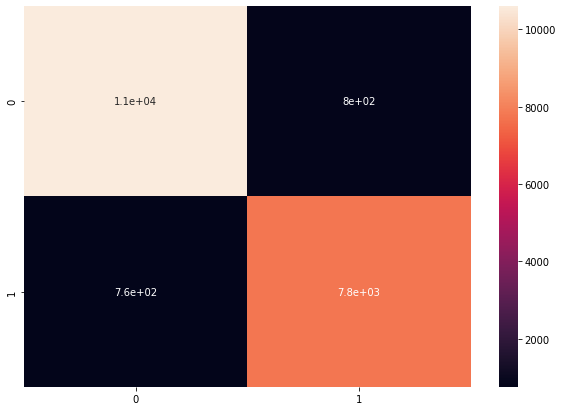

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(matrix, index = [i for i in "01"],
                  columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
matrix = classification_report(actual,predicted,labels=[0,1], output_dict=True)
print('Classification report : \n',matrix)
accuracy_score(actual, predicted)

Classification report : 
 {'0': {'precision': 0.933086811058285, 'recall': 0.9295675817910709, 'f1-score': 0.9313238718748628, 'support': 11401}, '1': {'precision': 0.9062135015183368, 'recall': 0.910787651132762, 'f1-score': 0.9084948188045197, 'support': 8519}, 'accuracy': 0.9215361445783132, 'macro avg': {'precision': 0.9196501562883108, 'recall': 0.9201776164619164, 'f1-score': 0.9199093453396912, 'support': 19920}, 'weighted avg': {'precision': 0.9215941542324406, 'recall': 0.9215361445783132, 'f1-score': 0.9215607843695287, 'support': 19920}}


0.9215361445783132

In [ ]:
matrix_df = pd.DataFrame(matrix).transpose()
if save_results:
  matrix_df.to_csv(save_path + "/classification_report_conv_3_node3_pi.csv", header=True, index=True)

